In [1]:
# pip install -r requirements.txt -q

In [90]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kenda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


-----

# Topic Modeling with OMDB Plots

Load in OMDB Data

In [60]:
omdb2020 = pd.read_csv("data/OMDBData2020.csv")
omdb2020.Plot = omdb2020.Plot.fillna(value="")

omdb2021 = pd.read_csv("data/OMDBData2021.csv")
omdb2021.Plot = omdb2021.Plot.fillna(value="")

omdb = omdb2020.append(omdb2021)

Train TFIDF Vectorizer

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

tfidf_vectorizer_NMF = TfidfVectorizer(max_features = 20000, # only top 20k by freq
                                       lowercase = True, # drop capitalization
                                       ngram_range = (1,2), # include up to 2-grams, we can make this only 1 if needed
                                       min_df=1,  # note: absolute count of doc
                                       token_pattern = r'\b[a-z]{3,12}\b',   # remove short, non-word-like terms
                                       stop_words='english') # default English stopwords

tfidf_documents_NMF = tfidf_vectorizer_NMF.fit_transform(omdb["Plot"])
feature_names_NMF = tfidf_vectorizer_NMF.get_feature_names_out()

Train NMF for n = 2-10 topics.

In [62]:
from sklearn.decomposition import NMF
for num_topics in range(2, 11):
    nmf = NMF(
        n_components=num_topics,
        init='nndsvd', 
        random_state = 42
        )
    W = nmf.fit_transform(tfidf_documents_NMF)
    H = nmf.components_
    top_components = np.argsort(-H)[:, :10]
    
    topics = []
    for t in top_components:
        topic_words = []
        for w in t:
            topic_words.append(feature_names_NMF[w])
        topics.append(topic_words)
        
    print(f"{num_topics} Topics:")
    print(topics)
    print("\n")
        

2 Topics:
[['family', 'young', 'old', 'father', 'year', 'woman', 'year old', 'home', 'mother', 'finds'], ['life', 'new', 'film', 'story', 'world', 'documentary', 'york', 'new york', 'city', 'love']]


3 Topics:
[['family', 'young', 'old', 'father', 'woman', 'year', 'home', 'year old', 'mother', 'finds'], ['life', 'new', 'film', 'story', 'world', 'documentary', 'york', 'new york', 'city', 'love'], ['school', 'high', 'high school', 'students', 'senior', 'team', 'student', 'school football', 'school students', 'football']]


4 Topics:
[['family', 'young', 'father', 'woman', 'home', 'mother', 'son', 'wife', 'daughter', 'house'], ['life', 'new', 'film', 'story', 'world', 'documentary', 'york', 'new york', 'love', 'city'], ['school', 'high', 'high school', 'students', 'team', 'senior', 'student', 'school football', 'school students', 'football'], ['year', 'old', 'year old', 'old girl', 'finds', 'love', 'old daughter', 'girl', 'best', 'friend']]


5 Topics:
[['family', 'father', 'young', 'wom

------

### NYT Full Review Text

TFIDF and NMF on full NYT Review text

In [63]:
NYTReviews = pd.read_csv("data/NYTData_wReviewText.csv")

In [64]:
tfidf_vectorizer_NMF = TfidfVectorizer(max_features = 20000, # only top 5k by freq
                                       lowercase = True, # drop capitalization
                                       ngram_range = (1,2), # include up to 2-grams, we can make this only 1 if needed
                                       min_df=1,  # note: absolute count of doc
                                       token_pattern = r'\b[a-z]{3,12}\b',   # remove short, non-word-like terms
                                       stop_words='english') # default English stopwords

tfidf_documents_NMF = tfidf_vectorizer_NMF.fit_transform(NYTReviews["review_text"])
feature_names_NMF = tfidf_vectorizer_NMF.get_feature_names_out()

In [65]:
from sklearn.decomposition import NMF
for num_topics in range(2, 11):
    nmf = NMF(
        n_components=num_topics,
        init='nndsvd', 
        random_state = 42
        )
    W = nmf.fit_transform(tfidf_documents_NMF)
    H = nmf.components_
    top_components = np.argsort(-H)[:, :10]
    
    topics = []
    for t in top_components:
        topic_words = []
        for w in t:
            topic_words.append(feature_names_NMF[w])
        topics.append(topic_words)
        
    print(f"{num_topics} Topics:")
    print(topics)
    print("\n")

2 Topics:
[['movie', 'like', 'story', 'film', 'character', 'time', 'characters', 'family', 'man', 'life'], ['documentary', 'film', 'says', 'footage', 'new', 'people', 'interviews', 'work', 'black', 'world']]


3 Topics:
[['movie', 'like', 'story', 'film', 'character', 'time', 'characters', 'family', 'man', 'life'], ['documentary', 'film', 'says', 'footage', 'people', 'new', 'interviews', 'black', 'work', 'history'], ['oscar', 'oscar nominated', 'nominated', 'live action', 'short', 'colette', 'program', 'program hour', 'hour program', 'action']]


4 Topics:
[['movie', 'like', 'story', 'character', 'characters', 'film', 'time', 'family', 'man', 'woman'], ['film', 'documentary', 'says', 'people', 'camera', 'history', 'subjects', 'world', 'women', 'interviews'], ['oscar', 'oscar nominated', 'nominated', 'live action', 'short', 'colette', 'program', 'hour program', 'program hour', 'action'], ['music', 'new', 'rock', 'york', 'new york', 'musical', 'artist', 'band', 'movie', 'documentary']]



------

# Turn Topics into Features

## NMF Helper Functions

In [66]:
# lemmatize the text fields
def lemmatize(text_data): 
    lemmatizer = WordNetLemmatizer()
    
    lemmas = text_data.apply(lambda w: [lemmatizer.lemmatize(word) for word in re.split('\s+|-', w.lower())])
    return lemmas.apply(lambda s: " ".join(s))

In [67]:
# train a tfidf bag of words vectorizer
def tfidf_vecorization(data, ngram_range):
    tfidf_vectorizer_NMF = TfidfVectorizer(max_features = 20000, # only top 20k by freq
                                       lowercase = True, # drop capitalization
                                       ngram_range = ngram_range, # include up to n-grams
                                       min_df=1,  # note: absolute count of doc
                                       token_pattern = r'\b[a-z]{3,}\b',   # remove short, non-word-like terms
                                       stop_words='english') # default English stopwords

    tfidf_documents_NMF = tfidf_vectorizer_NMF.fit_transform(data)
    feature_names_NMF = tfidf_vectorizer_NMF.get_feature_names_out()
    
    return tfidf_documents_NMF, feature_names_NMF

In [80]:
# take TFIDF transformed data and train NMF
def trainNMF(tfidf, n_components):
    nmf = NMF(
        n_components=n_components,
        init='nndsvd', 
        random_state = 42
        )
    W = nmf.fit_transform(tfidf_documents_NMF)
    H = nmf.components_
    top_components = np.argsort(-H)[:, :10]

    topics = []
    for t in top_components:
        topic_words = []
        for w in t:
            topic_words.append(feature_names_NMF[w])
        topics.append(topic_words)
        
    return W, H, topics, nmf

## Load Movie Data

In [69]:
movie_data = pd.read_csv("data/joined_df.csv")
movie_data.Plot = movie_data.Plot.fillna(value="")

#### Average Plot Length
We can see that plots have on average ~60 words with a few outliers of longer plots. The distribution is significantly right skewed.

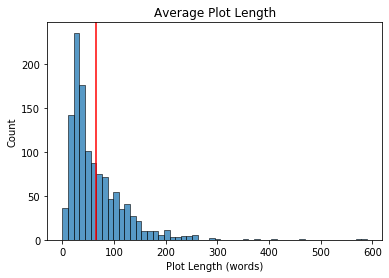

In [70]:
plot_length = movie_data["Plot"].apply(lambda x: len(x.split()))
sns.histplot(plot_length)
plt.axvline(x=plot_length.mean(),
            color='red');
plt.xlabel("Plot Length (words)")
plt.title("Average Plot Length");

#### Average Review Length
We can see that NYT reviews have on average ~400 words with a few outliers of longer revieews and shorter reviews. Most revies are not less than 200 words. Similar to plot lengths, the distribution is significantly right skewed.

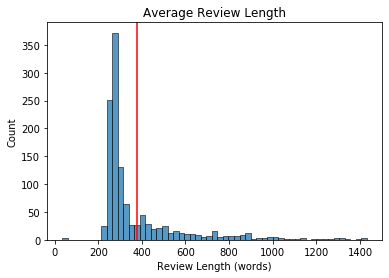

In [71]:
review_length = movie_data["review_text"].apply(lambda x: len(x.split()))
sns.histplot(review_length)
plt.axvline(x=review_length.mean(),
            color='red');
plt.xlabel("Review Length (words)")
plt.title("Average Review Length");

In [73]:
movie_data2 = movie_data.copy()

## Assign each movie a review topic

Using the W matrix, we can see which topic is most related to that movie's review.

In [97]:
movie_data['review_text'] = lemmatize(movie_data['review_text'])
tfidf_documents_NMF, feature_names_NMF = tfidf_vecorization(movie_data['review_text'], (1,1))
W, H, topics, nmf = trainNMF(tfidf_documents_NMF, 5)

In [98]:
# W is the topic matrix, the highest value within each row will determine the most relevant topic
movie_data["review_topic"] = [x.argmax() for x in W]

In [99]:
W_df = pd.DataFrame(W, columns = [f"reviewTopic{x}" for x in range(W.shape[1])])

movie_data2 = pd.DataFrame(
    np.column_stack([movie_data2,W_df]),
    columns=movie_data2.columns.append(W_df.columns)
)

#### Visualize Review Topics via WordCloud

Word Cloud code inspired by: https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911

Topic 1:


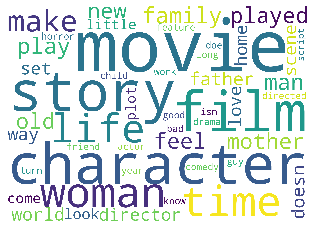

Topic 2:


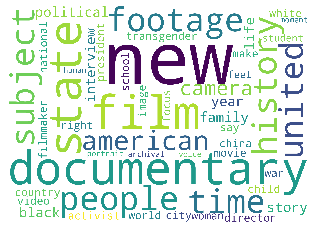

Topic 3:


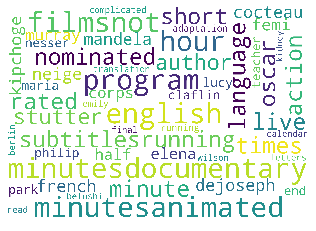

Topic 4:


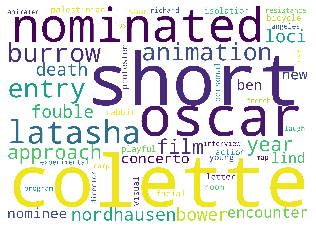

Topic 5:


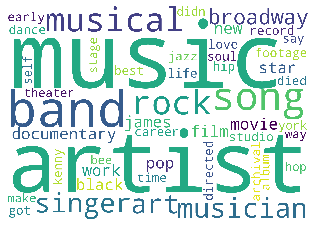

In [101]:
first_topic = nmf.components_[0]

for idx,topic in enumerate(nmf.components_):
    topic_words = [feature_names_NMF[i] for i in topic.argsort()[:-50 - 1 :-1]]
    print(f"Topic {idx+1}:")
    cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic_words))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

## Assign each movie a plot topic

Using the W matrix, we can see which topic is most related to that movie's plot. (Plot topics are different than review topics)

In [104]:
# movie_data['Plot'] = stemmer(movie_data['Plot'])
movie_data['Plot'] = lemmatize(movie_data['Plot'])
tfidf_documents_NMF, feature_names_NMF = tfidf_vecorization(movie_data['Plot'], (1,2))
W, H, topics, nmf = trainNMF(tfidf_documents_NMF, 5)

In [105]:
# W is the topic matrix, the highest value within each row will determine the most relevant topic
movie_data["plot_topic"] = [x.argmax() for x in W]

In [106]:
W_df = pd.DataFrame(W, columns = [f"plotTopic{x}" for x in range(W.shape[1])])

movie_data2 = pd.DataFrame(
    np.column_stack([movie_data2,W_df]),
    columns=movie_data2.columns.append(W_df.columns)
)

#### Visualize Plot Summary Topics via WordCloud

Word Cloud code inspired by: https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911

Topic 1:


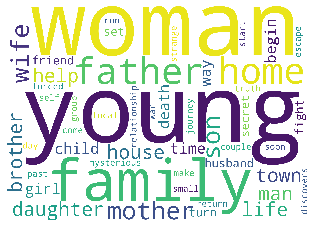

Topic 2:


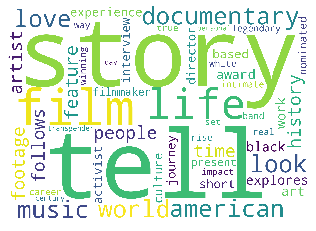

Topic 3:


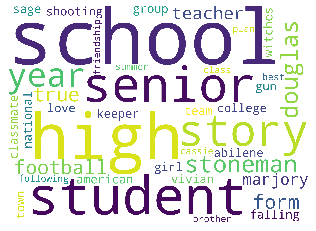

Topic 4:


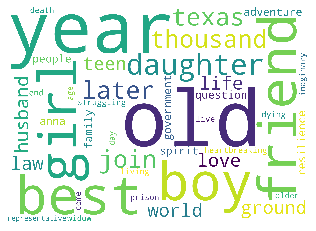

Topic 5:


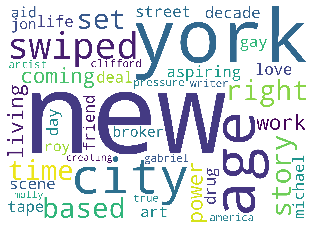

In [108]:
first_topic = nmf.components_[0]

for idx,topic in enumerate(nmf.components_):
    topic_words = [feature_names_NMF[i] for i in topic.argsort()[:-50 - 1 :-1]]
    print(f"Topic {idx+1}:")
    cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic_words))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

## Preview Data

#### Option 1
`movie_data` has 2 additional columns, each which show which topic is most closely related to the movie for full reviews and full plots.

In [20]:
movie_data[["Title", "Rated", "review_topic", "plot_topic"]].head(10)

,Title,Rated,review_topic,plot_topic
0,Tenet,PG-13,0,1
1,Dune,PG-13,0,1
2,Zack Snyder's Justice League,R,0,0
3,Soul,PG,4,2
4,Soul,PG,0,2
5,The Gentlemen,R,0,1
6,Black Widow,PG-13,0,0
7,The Suicide Squad,R,0,4
8,Shang-Chi and the Legend of the Ten Rings,PG-13,0,0
9,Wonder Woman 1984,PG-13,0,0


In [21]:
movie_data.to_csv("data/movie_data_withTopicAssignment.csv")

#### Option 2
`movie_data2` has columns based on **how** close each movie is to a given topic. The higher the value, the more related the topic.

In [22]:
movie_data2[["Title", "Rated",'reviewTopic0',
                 'reviewTopic1', 'reviewTopic2', 'reviewTopic3', 'reviewTopic4', 
                'plotTopic0', 'plotTopic1', 'plotTopic2', 'plotTopic3', 'plotTopic4']].head(10)

,Title,Rated,reviewTopic0,reviewTopic1,reviewTopic2,reviewTopic3,reviewTopic4,plotTopic0,plotTopic1,plotTopic2,plotTopic3,plotTopic4
0,Tenet,PG-13,0.078854,0.034304,0.007126,0.023031,0.0,0.022933,0.062822,0.0,0.006185,0.004514
1,Dune,PG-13,0.113677,0.009237,0.002602,0.00293,0.000837,0.041164,0.060843,0.0,0.0,0.0
2,Zack Snyder's Justice League,R,0.106864,0.016664,0.0146,0.0,0.0,0.042167,0.020683,0.005755,0.0,0.0
3,Soul,PG,0.071453,0.0,0.0,0.037547,0.106921,0.022669,0.023958,0.089829,0.0,0.0
4,Soul,PG,0.052249,0.00754,0.0,0.019459,0.0,0.022669,0.023958,0.089829,0.0,0.0
5,The Gentlemen,R,0.082745,0.0,0.0,0.0,0.013513,0.005333,0.051822,0.002413,0.0,0.000505
6,Black Widow,PG-13,0.085369,0.037605,0.0,0.0,0.0,0.030991,0.020254,0.000916,0.002431,0.002468
7,The Suicide Squad,R,0.084595,0.0,0.0,0.0,0.022584,0.023732,0.029311,0.022882,0.020559,0.049487
8,Shang-Chi and the Legend of the Ten Rings,PG-13,0.057941,0.015451,0.0,0.006728,0.012942,0.023629,0.008034,0.004488,0.002518,0.012717
9,Wonder Woman 1984,PG-13,0.128635,0.000305,0.0,0.0,0.001748,0.038651,0.012374,0.0,0.027426,0.0


In [23]:
movie_data2.to_csv("data/movie_data_withTopicRelatedness.csv")